<a href="https://colab.research.google.com/github/1040mxg/1040mxg.github.io/blob/master/5334proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

[Blog homepage](https://1040mxg.github.io/blog/) || [View on Github](https://github.com/1040mxg/5334project)

This project will build a classifier to detect specific media bias, and find the probability that a given piece of written news is by, or influenced by, Chinese state-sponsored media.


# Method

This project makes use of the Natural Language Toolkit (NLTK) to help process text. I will be using **Naive Bayes** as a base to build this classifier. Naive Bayes is a simple, fast, and accurate algorithm that works particularly well with natural language processing (NLP), or text classification. In my tests, I used the **Multinomial Naive Bayes** algorithm. It works by taking advantage of probability theory and Bayes' Theorem to classify text. For each piece of input text, the probability of each possible class is calculated and the final classification made based on highest probability.

I will first run the Naive Bayes classifier (NBC) through the datasets separated by topic, then all as one.

In [ ]:
pip install --user -U nltk

# Preprocessing

First, I import the desired files and load necessary libraries. Here, I've imported the NLTK corpus of English-language stopwords (common articles and prepositions such as "the", "an", "there" that are largely irrelevant in data mining).

In [391]:
###import necessary libaries
import nltk
from nltk.corpus import words, stopwords
nltk.download('stopwords')
nltk.download('words')
from nltk import ngrams
from collections import Counter

stopwords = stopwords.words('english')
words = words.words()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


I combine all the data from each source into one here, but the data can also be analysed by topic.

In [392]:
filenames1 = ['tweets_xh_hk.txt', 'tweets_xh_taiwan.txt', 'tweets_xh_xinjiang.txt']
filenames2 = ['tweets_npr_hk.txt', 'tweets_npr_tw.txt', 'tweets_npr_xinjiang.txt']

with open('tweets_xh_all.txt', 'w') as outfile:
    for names in filenames1:
        with open(names) as infile:
            outfile.write(infile.read())

with open('tweets_npr_all.txt', 'w') as outfile:
    for names in filenames2:
        with open(names) as infile:
            outfile.write(infile.read())

X = []
y = []

Then I load in the data from NPR and Xinhua News, label them, and combine them into one dataset.

In [393]:
##import data files and print some basic stats
###data files will default to combined data unless specified

def loadData(file1 = "tweets_xh_all.txt", file2="tweets_npr_all.txt"):
#first, load the XH and NPR data individually
  xhData = []
  nprData = []
  with open(file1, 'r') as f:
    for row in f:
      xhData.append(row+'0')
  with open(file2, 'r') as f:
    for row in f:
      nprData.append(row+'1')
  print("XH items:", len(xhData))
  print("NPR items:", len(nprData))


#compile the NPR and XH files into one
  data = []
  for i in range(len(xhData)):
    if len(xhData[i]) > 25:
      data.append([xhData[i], '0'])
  for i in range(len(nprData)):
    if len(nprData[i]) > 25:
      data.append([nprData[i], '1'])
  print("Total data items:", len(data))
  return data

data = loadData()

XH items: 6299
NPR items: 698
Total data items: 6710


Next, I shuffle the data and split it into training, dev, and test sets.

In [394]:
import random

random.seed(1)
random.shuffle(data)
dataLen = len(data)
print(dataLen)

###manual division
testLen = int(.2*dataLen)
devLen = int(.2*(dataLen - testLen))
trainLen = dataLen - testLen - devLen

train = []
dev = []
test =[]
for i in range(trainLen):
  train.append(data[i])

for i in range(trainLen, trainLen+devLen):
  dev.append(data[i])

for i in range(dataLen-testLen, dataLen):
  test.append(data[i])

print("Train Data: %d items" %(len(train)))
print("Dev Data: %d items" %(len(dev)))
print("Test Data: %d items" %(len(test)))

6710
Train Data: 4295 items
Dev Data: 1073 items
Test Data: 1342 items


# Training

The training set is split into two lists based on source.

In [395]:
def split(data):
  nprStr = []
  xhStr = []
  for i in range(len(data)):
    if data[i][-1] == '1':
      nprStr.append(data[i][0])
    elif data[i][-1] == '0':
      xhStr.append(data[i][0])
  return nprStr, xhStr

def printSample(nprStr, xhStr):
  print("Xinhua Tweets: %d items" %(len(xhStr)))
  print("---------------Sample---------------")
  for i in range(5):
    if(len(xhStr[i])>80):
      print("%s..." %xhStr[i][0:80])
    else:
      print(xhStr[i], end='')
  print("\n")
  print("NPR Tweets: %d items" %(len(nprStr)))
  print("---------------Sample---------------")
  for i in range(5):
    if(len(nprStr[i])>80):
      print("%s..." %nprStr[i][0:80])
    else:
      print(nprStr[i], end='')

nprStr, xhStr = split(train)
printSample(nprStr, xhStr)

Xinhua Tweets: 3985 items
---------------Sample---------------
Ethnic groups in Xinjiang are part of Chinese nation: white paper xhne.ws/znLOe ...
3. Panda recognition tech xhne.ws/oKuA9 https://t.co/gjVitH2EFX"
0Hong Kong immigration director vows to attract more talents xhne.ws/Zs4nP (Xinhu...
Findings at the caves, dubbed "gateway to heaven", will fill the gap of Xinjiang...
300-km-long desert road, crossing China's largest desert Taklimakan nicknamed "S...


NPR Tweets: 310 items
---------------Sample---------------
The association has been ordered to pay the equivalent of $15,000 and was given ...
A Hong Kong district court has found nine activists guilty of public nuisance cr...
Hong Kong has 110 McDonalds outlets that are open 24 hours, and they are relucta...
Beijing Brushes Aside Hong Kongs Rejection Of Electoral Reform n.pr/1Bm1nz0
1After bringing the number of local coronavirus cases down to zero, Hong Kong is ...


The data lists are further processed into dictionaries of vocabularies. 
Each line in the lists was split into individual words and added to a temporary dictionary. This temporary dictionary was then trimmed to include only words that do not appear in the list of stopwords.

In [396]:
import re

#trainset vocab list + split into npr/xh
def splitWord(strings, tempDict):
  words = 0
  for line in strings:
    line = line.lower()
    temp = re.findall(r'\w+', line)
    for word in temp:
      words+=1
      if word in tempDict:
        tempDict[word] +=1
      else:
        tempDict[word] = 1

def trim(strings, tempDict):
  keys = list(tempDict.keys())
  vals = list(tempDict.values())
  newDict = dict()
  count = 0
  for i in range(len(vals)):
    k = keys[i]
    if k not in stopwords and k in words:
      newDict[k] = vals[i]
      count+=vals[i]
  return newDict, count

def makeVocab(strings):
  tempDict = dict()
  splitWord(strings, tempDict)
  newDict, count = trim(strings, tempDict)
  return newDict, count

print("---------------Xinhua Word List---------------")
xhVocab, xhCount = makeVocab(xhStr)
print("Words After Trimming: ", xhCount)
print("Unique Words: %d\n" %len(xhVocab))

print("---------------NPR Word List---------------")
nprVocab, nprCount = makeVocab(nprStr)
print("Words After Trimming: ", nprCount)
print("Unique Words: %d\n" %len(nprVocab))

print("---------------All Words---------------")
allVocab = {**nprVocab, **xhVocab}
allCount = nprCount+xhCount
print("Total Word Count: ", allCount)
print("Unique Words: ", len(allVocab))

# print("Positive:", nprVocab)
# print("Negative:", xhVocab)
# print("All:", allVocab)  

---------------Xinhua Word List---------------
Words After Trimming:  32761
Unique Words: 4532

---------------NPR Word List---------------
Words After Trimming:  2541
Unique Words: 1046

---------------All Words---------------
Total Word Count:  35302
Unique Words:  4759


P(xh) and P(npr) were calculated by dividing the count of each by the total (trimmed) word count.

Individual P(word|author) were calculated using (#word in class)/(#total word count in sentiment class). A general P(word) was also calculated using (#word/#total word count). All three were stored in new dictionaries.

In addition, one major issue that Naive Bayes faces in text classification is missing data. When a word does not appear in a class, making P(word|class) = 0, that probability gets multiplied out to all the other probabilities in determining P(class), making P(class) = 0.

Laplace smoothing is a method of combatting this issue. The process is:
1.   Add 1 to every count so P(word|class) will always > 0.
2.   Balance this by adding the number of possible words to the divisor so the result will never < 1.


In [397]:
#get probabilities for P(npr), P(xh) based on trimmed word counts
allCount = nprCount+xhCount
print("---------------Probabilities---------------")
print("P(npr) = %d/%d = %.5f" %(nprCount, allCount, nprCount/allCount))
print("P(xh) = %d/%d = %.5f\n" %(xhCount, allCount, xhCount/allCount))

##laplace smoothing
nprCount+=len(allVocab)
xhCount+=len(allVocab)
allCount = nprCount+xhCount
#for test words of P=0
noNPR = 1/nprCount
noXH = 1/xhCount

#get individual P(word|class) and store in dictionary
def getProbs(Dict, PCount):
  keys = list(Dict.keys())
  vals = list(Dict.values())
  newDict = dict()
  for i in range(len(vals)):
    k = keys[i]
    p = vals[i]/PCount
    newDict[k] = p
  return newDict

nprProb = getProbs(nprVocab, nprCount)
xhProb = getProbs(xhVocab, xhCount)
allProb = getProbs(allVocab, allCount)

print("---------------P(word) Sample---------------")
print({k: allProb[k] for k in list(allProb)[:5]}, "\n")

print("---------------P(word|npr) Sample---------------")
print({k: nprProb[k] for k in list(nprProb)[:5]}, "\n")

print("---------------P(word|xh) Sample---------------")
print({k: xhProb[k] for k in list(xhProb)[:5]})

---------------Probabilities---------------
P(npr) = 2541/35302 = 0.07198
P(xh) = 32761/35302 = 0.92802

---------------P(word) Sample---------------
{'association': 0.00015618027666220436, 'ordered': 2.2311468094600625e-05, 'pay': 2.2311468094600625e-05, 'equivalent': 2.2311468094600625e-05, 'given': 0.00015618027666220436} 

---------------P(word|npr) Sample---------------
{'association': 0.000273972602739726, 'ordered': 0.000136986301369863, 'pay': 0.000136986301369863, 'equivalent': 0.000136986301369863, 'given': 0.00041095890410958907} 

---------------P(word|xh) Sample---------------
{'ethnic': 0.0010394456289978678, 'part': 0.0008528784648187633, 'nation': 0.0002398720682302772, 'white': 0.0013326226012793177, 'paper': 0.0012260127931769723}


# Testing Model with Dev Set

First, just applying the algorithm directing to the dev set:


In [398]:
def splitTrim(line):
  words = []
  temp = re.findall(r'\w+', line)
  for i in temp:
    if len(i)>2:
      words.append(i)
  #print(words)
  return words

#with Laplace smoothing
def naiveBayes(line, vocab0, vocab1):
  words = splitTrim(line)
  p_npr = 1
  p_xh = 1
  for word in words:
    if word in vocab1:
      p_npr = nprProb[word]*p_npr
    else:
      p_npr = p_npr*noNPR
    if word in vocab0:
      p_xh = xhProb[word]*p_xh
    else:
      p_xh = p_xh*noXH
  if p_npr < p_xh:
    pred = 0
  elif p_npr > p_xh:
    pred = 1
  else:
    return 2
  return pred

def predict(data, algorithm=naiveBayes, vocab0=xhVocab, vocab1=nprVocab):
  correct = 0
  total = 0
  for line in data:
    actual = int(line[-1])
    pred = algorithm(line[0], vocab0, vocab1)
    #print("Test: ",pred, actual)
    if pred == actual:
      correct+=1
      total+=1
    else:
      total+=1
  acc = correct/total
  return acc, correct, total

acc, correct, total = predict(dev)
acc = acc*100
print("Accuracy: %.3f " %acc, "%")

X.append("Dev")
y.append(acc)

Accuracy: 9.413  %


**Five-Fold Cross Validation**

This tests the algorithm using cross validation. The process is as follows:
1.   Split the data into 5 groups
2.   For each group, use it as a test set with the remaining groups as training sets
3.   Fit a model on the training set and evaluate on the test set
4.   Repeat the above until all samples have had a turn as a test set
5.   Find the mean accuracy

In [399]:
#split dataset into 5 folds
def crossValsplit(dataset):
  folds = 5
  data_split = list()
  data_copy = list(dataset)
  fold_size = int(len(dataset)/folds)
  for i in range(folds):
    fold = list()
    while len(fold) < fold_size:
      index = randrange(len(data_copy))
      fold.append(data_copy.pop(index))
    data_split.append(fold)
  return data_split

def evaluate(data):
  folds = crossValsplit(data)
  scores = list()
  for fold in folds:
    train = list(folds)
    train.remove(fold)
    train = sum(train, [])
    test = list()
    for row in fold:
      test.append(row)
    #create new dictionaries based on fold
    x_nprStr, x_xhStr = split(train)
    x_nprVocab, x_nprCount = makeVocab(x_nprStr)
    x_xhVocab, x_xhCount = makeVocab(x_xhStr)
    x_allVocab = {**x_nprVocab, **x_xhVocab}
    x_allCount = x_nprCount+x_xhCount
    x_nprProb = getProbs(x_nprVocab, x_nprCount)
    x_xhProb = getProbs(x_xhVocab, x_xhCount)
    x_allProb = getProbs(x_allVocab, x_allCount)
    acc, correct, total = predict(test)
    acc = acc*100
    scores.append(acc)
  print("Scores: %s" %scores)
  mean = sum(scores)/float(len(scores))
  print('Mean Accuracy: %.3f%%' %mean)
    
mean = evaluate(dev)

X.append("X-valid")
y.append(mean)

Scores: [9.813084112149532, 7.476635514018691, 14.018691588785046, 7.943925233644859, 7.943925233644859]
Mean Accuracy: 9.439%


Even with Laplace smoothing, the algorithm is not very accurate, on either the cross-validation or applied directly to the dev data. 


# Experiments

I will start approaching this problem from a few different directions.

First, instead of a pure "yes/no" comparison, I want to see how the classifier and training data do in predicting P(class).

Loading a new dataset of only Xinhua data and leaving it unlabelled.

In [400]:
newData = []

with open("tweets_xh_hk.txt", 'r') as f:
    for row in f:
      newData.append(row)

for i in range(5):
  print(newData[i][0:80], "...")

The 2020 policy address delivered by HKSAR Chief Executive Carrie Lam has won st ...
The national security law in China's Hong Kong has been remarkably effective in  ...
Hong Kong embraces greater development opportunities with new policy address unv ...
HKSAR Chief Executive Carrie Lam delivered the 2020 policy address, highlighting ...
The central authorities will fully support Hong Kong's development in 7 aspects  ...


Adjusting the Naive Bayes method to return P(class) instead of a prediction and taking the mean probability of each class.

In [401]:
import numpy as np

#with Laplace smoothing
def naiveBayesPoss(line, vocab0, vocab1):
  words = splitTrim(line)
  #print(words)
  p_npr = 1
  p_xh = 1
  for word in words:
    if word in vocab1:
      p_npr = nprProb[word]*p_npr
    else:
      p_npr = p_npr*noNPR
    if word in vocab0:
      p_xh = xhProb[word]*p_xh
    else:
      p_xh = p_xh*noXH
  return p_npr, p_xh

def predictPoss(data, vocab0=xhVocab, vocab1=nprVocab):
  arrNPR = []
  arrXH = []
  for line in data:
    #print(line)
    predNPR, predXH = naiveBayesPoss(line, vocab0, vocab1)
    arrNPR.append(predNPR)
    arrXH.append(predXH)
    #print("Test: ",pred, actual)
  possNPR = np.mean(arrNPR)
  possXH = np.mean(arrXH)
  return possNPR, possXH

possNPR, possXH = predictPoss(newData)
print('Mean possXH: %.3f%%' %possXH)
print('Mean possNPR: %.3f%%' %possNPR)

X.append("Mean\nP(class)")
y.append(possXH)

Mean possXH: 0.002%
Mean possNPR: 0.002%


Given that the data used in the experiment above *only* came from Xinhua, the mean P(class) should have been much higher than it is, or at least higher than possNPR.

**Top Words**

Next, I will derive the top 10 words for predicting class, ie. the top 10 each of P(Positive|word) and P(Negative|word). Given that:

$P(class|word)=\frac{P(word|class)P(class)}{P(word)}$

and I already have the values for P(word), P(class), and P(word|class), this will be a simple matter of finding the top 10 values.

In [402]:
"""
Find the top ten P(class|word) for each class
"""
def topTen(classDict, classCount):
  words = []
  probs = []
  #keys = word, vals = P(word|class)
  keys = list(classDict.keys())
  vals = list(classDict.values())
  pClass = classCount/allCount
  for i in range(len(keys)):
    pWord = allProb[(keys[i])]
    p = (vals[i]*pClass)/pWord
    words.append(keys[i])
    probs.append(p)
  top = sorted(range(len(probs)), key=lambda i: probs[i])[-10:]
  topWords = []
  for i in top:
    topWords.append(words[i])
  return topWords

topNPR = topTen(nprProb, nprCount)
topXH = topTen(xhProb, xhCount)

print("Top NPR Words:")
print(topNPR)
print("\nTop XH Words:")
print(topXH)

acc, correct, total = predict(data, algorithm=naiveBayes, vocab0=topXH, vocab1=topNPR)
acc = acc*100
print("\nAccuracy, Top10 Words: %.3f%%" %acc)

X.append("Top10")
y.append(acc)

Top NPR Words:
['whose', 'enemy', 'withdraw', 'remarkably', 'shut', 'strike', 'tear', 'extradition', 'pro', 'n']

Top XH Words:
['struck', 'heart', 'migrant', 'properly', 'policeman', 'afternoon', 'bloom', 'therapy', 'low', 'battle']

Accuracy, Top10 Words: 7.481%


Changing the parameters to top 10 words only decreased accuracy.

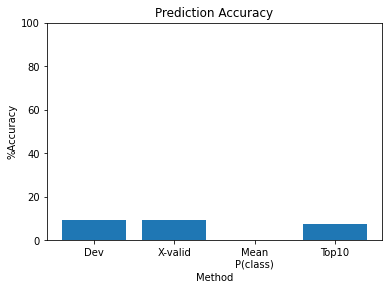

In [415]:
import matplotlib.pyplot as plt

y[1] = 9.439

plt.title("Prediction Accuracy")
plt.ylim(0,100)
plt.xlabel("Method")
plt.ylabel("%Accuracy")
plt.bar(X,y)
plt.show()

None of these methods are very strong. Clearly, this dataset is very different from something like a dataset of movie reviews. Even though the general idea is similar (movie reviews using "positive" and "negative" words to find sentiment), 

# Analysis

# References

*   Bruno Stecanella, "A practical explanation of a Naive Bayes classifier", https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/
*   Jason Brownlee, "Naive Bayes Classifier From Scratch in Python
", https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/


